<a href="https://colab.research.google.com/github/GuoyaoShen/DiatomDL/blob/main/main_v_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script works as a main script of v1.0 for testing

# Mount Drive

In [332]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading
* might need stacking data in future

In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, transforms

In [334]:
# path_reflection = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/Diatom_vis_1_reflection.txt'
# path_transmission = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/Diatom_vis_1_transmission.txt'

# data_reflection = np.loadtxt(path_reflection, skiprows=2)
# data_transmission = np.loadtxt(path_transmission, skiprows=2)

In [335]:
# print(data_reflection.shape)
# print(data_reflection)
# print(data_reflection[:,0])
# print('===============================================')
# print(data_transmission.shape)
# print(data_transmission)
# print(data_transmission[:,0])

# freq = data_reflection[:,0]
# reflect = data_reflection[:,1]
# transmit = data_transmission[:,1]
# absorb = 1-reflect**2-transmit**2

In [336]:
# plt.figure(1)
# plt.plot(data_reflection[:,0], data_reflection[:,1])
# plt.figure(2)
# plt.plot(data_transmission[:,0], data_transmission[:,1])
# plt.figure(3)
# plt.plot(freq, absorb)

In [337]:
# plt.figure(1)
# plt.scatter(data_reflection[::10,0], data_reflection[::10,1])
# plt.figure(2)
# plt.plot(data_transmission[::2,0], data_transmission[::2,1])

In [338]:
path_reflection = '/content/drive/My Drive/BU Class/Research/BioDL_Project/data/test1.txt'
data_reflection = np.loadtxt(path_reflection)

In [339]:
# CORE PART OF READING DATA

num_combination = 0
with open(path_reflection) as f:
    lines=f.readlines()

    spectra_ref_all = np.array([]).reshape(0,1001,2)  # shape for each spectra: [1001,2]
    spectra_ref = np.array([]).reshape(0,2)
    param_all = np.array([]).reshape(0,11)

    for i, line in enumerate(lines):
        if (i%1004!=0) & (i%1004!=1) & (i%1004!=2): # read spectra data
            line_array = np.fromstring(line, dtype=float, sep=' ')
            # print(i)
            # print(spectra_ref.shape)
            # print(line_array)
            # print(line_array.shape)
            # print('=====')
            spectra_ref = np.vstack((spectra_ref, line_array))

        if i%1004==0:  # every (3+1001) lines, read param title
            # print(num_combination, i, line.strip())
            param = [float(s) for s in re.findall(r"[-+]?\d*\.\d+|\d+", line)]  # extract the float param
            # print(num_combination, param)
            # print('------------')
            param_all = np.vstack((param_all, param))
            num_combination += 1

        if i%1004==1003:  # every end of the combination, concat
            # print(num_combination)
            spectra_ref_all = np.concatenate((spectra_ref_all, spectra_ref[np.newaxis, ...]), axis=0)
            spectra_ref = np.array([]).reshape(0,2)

In [340]:
print(spectra_ref_all.shape)
print(param_all.shape)

(25, 1001, 2)
(25, 11)


In [341]:
spectra_ref_all = spectra_ref_all[...,1]

param_all = param_all[...,1]
param_all = param_all[...,np.newaxis]

print(spectra_ref_all.shape)
print(param_all.shape)

(25, 1001)
(25, 1)


## Create Dataset

In [342]:
tensor_x = torch.Tensor(param_all) # transform to torch tensor
tensor_y = torch.Tensor(spectra_ref_all)

print(tensor_x.shape)
print(tensor_y.shape)

dataset_ref = TensorDataset(tensor_x,tensor_y)
dataloader_ref = DataLoader(dataset_ref)

torch.Size([25, 1])
torch.Size([25, 1001])


# Model

## Model Construct

In [343]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class SquareLayer(nn.Module):
    '''
    This layer works as a function of: y = xAx+(Bx)+C
    '''
    def __init__(self, dim_in, dim_out):
        super(SquareLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out, bias=False)
        self.bilinear = nn.Bilinear(dim_in, dim_in, dim_out)

    def forward(self, x):
        out = self.linear(x) + self.bilinear(x,x)
        return  out


class NetDense(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetDense, self).__init__()
        self.ksz1d = 50

        self.fc_encoder = nn.Sequential(
        # SquareLayer(dim_in, 100),
        nn.Linear(dim_in, 100),
        nn.ReLU(True),
        nn.Linear(100, 500),
        nn.ReLU(True),
        nn.Linear(500, 1500),
        nn.ReLU(True),
        nn.Linear(1500, 3000),
        nn.ReLU(True),
        nn.Linear(3000, 2500),
        nn.ReLU(True),
        nn.Linear(2500, dim_out),
        nn.ReLU(True),
        # nn.Linear(2500, dim_out+self.ksz1d-1),
        # nn.ReLU(True),
        # nn.Linear(2000, dim_out+self.ksz1d+1),
        # nn.ReLU(True),
        # nn.Linear(1500, 500),
        # nn.ReLU(True),
        # nn.Linear(1500, 500),
        )

        self.conv = nn.Conv1d(1, 1, kernel_size=self.ksz1d, stride=1)

        # self.conv_decoder = nn.Sequential(
        # pass
        # )

    

    def forward(self, x):
        out = self.fc_encoder(x)
        # # print(out.shape[0])
        # out = out.view(out.shape[0], 1, out.shape[1])
        # # print(out.shape)
        # out = self.conv(out)
        # # print(out.shape)
        # out = out.view(out.shape[0], out.shape[2])

        return out

In [344]:
# datain = torch.randn(7, 1, 5)
# conv = nn.Conv1d(1, 1, kernel_size=3, stride=1)
# dataout = conv(datain)
# print(dataout.shape)

## Train & Test Function

In [345]:
def train_model(train_dataloader, optimizer, loss, net, device, NUM_EPOCH=5, scheduler=None):
    net.train()

    if scheduler != None:
        print('*** WILL USE SCHEDULER ***')

    for i in range(NUM_EPOCH):
        running_loss = 0.0
        # running_acc = 0.0
        for idx, data in enumerate(train_dataloader):
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # if idx==0:
            #     print(X.shape, y.shape)

            y_pred = net(X)

            optimizer.zero_grad()
            loss_train = loss(y_pred, y)
            loss_train.backward()
            optimizer.step()
            running_loss += loss_train.item()

            if (idx+1)%5==0:
                print('EPOCH '+str(i+1)+'/'+str(NUM_EPOCH)+' || '+'STEP '+str(idx+1)+'/'+str(len(train_dataloader))+' || '+'LOSS: '+str(running_loss/(idx+1)))
                print('===================================================')
        print('----------------------------------------------------------------------')
        print('*** EPOCH '+str(i+1)+' || AVG LOSS '+str(running_loss/(idx+1)))
        print('----------------------------------------------------------------------')

# Train & Test

In [346]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-3

torch.manual_seed(123)

net_dense = NetDense(1,1001)

optimizer = torch.optim.Adam(net_dense.parameters(), lr=learning_rate)
criteon = nn.MSELoss()
scheduler = None


train_model(dataloader_ref, optimizer, criteon, net_dense, device, NUM_EPOCH=20, scheduler=scheduler)

EPOCH 1/20 || STEP 5/25 || LOSS: 0.25069540813565255
EPOCH 1/20 || STEP 10/25 || LOSS: 0.18231487832963467
EPOCH 1/20 || STEP 15/25 || LOSS: 0.1733138494193554
EPOCH 1/20 || STEP 20/25 || LOSS: 0.16840528827160597
EPOCH 1/20 || STEP 25/25 || LOSS: 0.16935066029429435
----------------------------------------------------------------------
*** EPOCH 1 || AVG LOSS 0.16935066029429435
----------------------------------------------------------------------
EPOCH 2/20 || STEP 5/25 || LOSS: 0.13604527711868286
EPOCH 2/20 || STEP 10/25 || LOSS: 0.10499187186360359
EPOCH 2/20 || STEP 15/25 || LOSS: 0.11824319114287694
EPOCH 2/20 || STEP 20/25 || LOSS: 0.122177311219275
EPOCH 2/20 || STEP 25/25 || LOSS: 0.12491577059030533
----------------------------------------------------------------------
*** EPOCH 2 || AVG LOSS 0.12491577059030533
----------------------------------------------------------------------
EPOCH 3/20 || STEP 5/25 || LOSS: 0.14936750382184982
EPOCH 3/20 || STEP 10/25 || LOSS: 0.1261

torch.Size([25, 1])
torch.Size([25, 1001])
torch.Size([1, 1])
torch.Size([1, 1001])
[[0.7420308  0.7422049  0.74063647 ... 0.3855536  0.         0.38675523]]


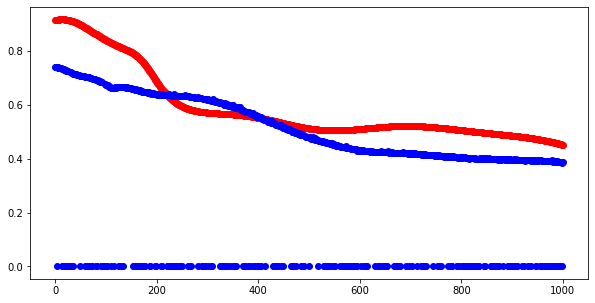

In [347]:
idx_test = 12
print(tensor_x.shape)
print(tensor_y.shape)

# X_test = tensor_x[idx_test,:].unsqueeze(0)
# y_test = tensor_y[idx_test,:].unsqueeze(0)

print(X_test.shape)
print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
# print(y_test.shape)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()
print(y_test_pred_np)

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(10,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')

torch.Size([25, 1])
torch.Size([25, 1001])


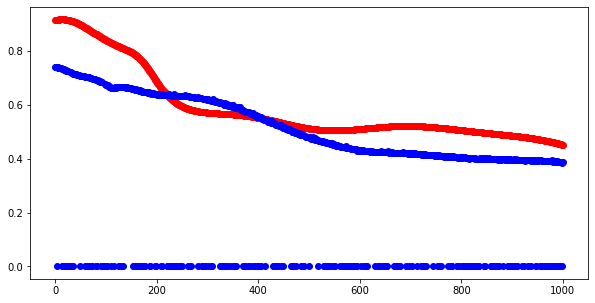

In [348]:
idx_test = 21
print(tensor_x.shape)
print(tensor_y.shape)

X_test = tensor_x[idx_test,:]
y_test = tensor_y[idx_test,:]

# X_test = tensor_x[idx_test,:].unsqueeze(0)
# y_test = tensor_y[idx_test,:].unsqueeze(0)

# print(X_test.shape)
# print(y_test.shape)

X_test = X_test.to(device)
y_test_pred = net_dense(X_test)
# print(y_test.shape)

y_test_np = y_test.cpu().detach().numpy()
y_test_pred_np = y_test_pred.cpu().detach().numpy()

# plt.figure(1)
# plt.plot(np.arange(1001), y_test_np)
# plt.figure(2)
# plt.plot(np.arange(1001), y_test_pred_np)

plt.figure(3, figsize=(10,5))
plt.scatter(np.arange(1001), y_test_np, c='r')
plt.scatter(np.arange(1001), y_test_pred_np, c='b')